# Instanton interactions
The programme allows to study instanton interactions in a double well potential $V(x)=\left(x^2-\eta^2\right)^2$ exploiting various computational techniques (sum ansatz, Monte Carlo simulations, streamline equation method).

Input parameters, with default values:
- potential parameters: $\eta=1.4$
- mass of the particle: $m=0.5$
- number of lattice points: $N=800$
- lattice spacing: $a=0.05$
- number of Metropolis sweeps: $N_{sweeps}=100$
- number of sweeps between each measurement: $N_{cor}=100$
- number of cooling sweeps: $N_{cool}=10$
- number of instantons in the sum ansatz: $N_{in}=10$
- average instanton position update: $\Delta z=1$
- hard core interaction radius: $r_{core}=0.3$
- hard core interaction strength: $A_{core}=3$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import math
import random
from tqdm.notebook import tqdm
import itertools                       # Needed for list of lists merging

In [2]:
# Parameters of the potential
Lambda = float(input("lambda = ") or 1)
eta = float(input("eta = ") or 1.4)
m = float(input("m = ") or 1/2)
hbar = 1;

lambda = 
eta = 
m = 


In [3]:
# Lattice parameters
N = int(input("N = ") or 800)
a = float(input("a = ") or 0.05)

N = 
a = 


### Instanton number estimate and sum ansatz
The instanton number estimate and the building of the sum ansatz is the same as in the random instanton approximation.

In [4]:
# Number of instantons, semiclassical estimate
S0 = 4*eta**3/3
instdens1 = 8*np.sqrt(2/np.pi)*eta**2.5*np.exp(-S0)           # One-loop
instdens2 = instdens1*np.exp(-71/(72*S0))                     # Two-loop

beta = N*a                     # Total euclidean time
Nin1 = instdens1*beta
Nin2 = instdens2*beta

Nin_exp1 = round(Nin1)         # Expected number of instantons
Nin_exp2 = round(Nin2)

print('One-loop estimate: Nin = ' + str(Nin_exp1))
print('Two-loop estimate: Nin = ' + str(Nin_exp2))

Nin = int(input("Nin = ") or Nin_exp2)

One-loop estimate: Nin = 15
Two-loop estimate: Nin = 12
Nin = 


In [5]:
# Fixing the instanton positions randomly
def setup(Nin, z, beta):    
    for j in range(Nin):
        z[j] = random.random()*beta     # Random instanton positions collected in vector z
    
    
# Function that generates the sum ansatz
def sum_ans(Nin, eta, z, t):
    Neven = Nin - Nin%2          # Taking only half of Nin values
    xsum = -eta                  # Initial value for sum ansatz
    
    for j in range(1, Neven, 2):                                                          # Loop every two values of j
        xsum = xsum + eta*np.tanh(2*eta*(t-z[j-1])) - eta*np.tanh(2*eta*(t-z[j]))         # Building the ansatz
    
    if Nin%2 != 0:
        xsum = xsum + eta*np.tanh(2*eta*(t-z[Nin-1])) + eta                               # Added term
    
    return xsum


# Function that computes the sum ansatz on the lattice x
def xconf(Nin, eta, z, x):
    for j in range(N):
        xt = a*j
        x[j] = sum_ans(Nin, eta, z, xt)

In [6]:
# Function that evaluates the action of a given configuration
def S(x):
    Action = (x[0] - x[N-1])**2 / (4*a) + a*(x[0]**2 - eta**2)**2
    
    for j in range(1, N):
        Action = Action + (x[j] - x[j-1])**2 / (4*a) + a*(x[j]**2 - eta**2)**2
    
    return Action

### Distance between instantons
The distance between instantons is computed by evaluating the distance between zero crossings of the path. if $x_jx_{j+1}<0$, so that in between there is a zero of the function, the zero crossing is roughly estimated as:

$$
x_{cross}\approx\frac{x_j+x_{j+1}}{2}= \frac{(j+1) + j}{2}a = \frac{2j+1}{2}a
$$

and the distances are computed as $d_j = |x_{cross,\ 2j}-x_{cross,\ 2j+1}|$ for $j=0,\dots, \frac{1}{2}N_{cross}$, being $N_{cross}$ the number of zero crossings (which is forced to be even).

In [7]:
# Function that computes the distance between instantons in a given configuration
def dist(x):
    zcross = []          # List of zero crossings
    
    for j in range(len(x)-1):
        if x[j]*x[j+1] < 0:                # Zero crossing condition
            mean = a*(2*j+1) / 2           # Rough estimate of the zero crossing point
            zcross.append(mean)            # Add item to list
    
    if len(zcross)%2 != 0:                 # The zero crossing vector should have an even number of elements
        zcross.pop()
    
    dist = []            # List of distances
    
    for j in range(int(len(zcross)/2)):
        dist.append( np.abs(zcross[2*j] - zcross[2*j+1]) )              # Distance between instantons
        
    return dist

## Sum ansatz and instanton interactions
The interacting term of the action can be easily evaluated for the sum ansatz by studying a couple of instantons separated by a certain distance $\tau_{IA}$. The following programme computes the full action for $N_{points}=40$ different separations between two instantons located in $x=0$ and $x=ja$, $j=1,\dots,N_{points}$.

In [22]:
Npoints = int(input("Npoints = ") or N/4)                 # Number of lattice points for sum ansatz computation

Sint_vec = np.zeros(Npoints)
tIA_vec = np.zeros(Npoints)
tIA_ZC = np.zeros(Npoints)
x = np.zeros(N)
z = np.zeros(2)

# Evaluating the interacting term for the sum ansatz
for j in range(Npoints+1, Npoints*2):
    z[0] = Npoints*a                                  # Instanton locations
    z[1] = j*a

    xconf(2, eta, z, x)                               # Build a sum ansatz with two instantons
    Action = S(x)
        
    Sint_vec[j-Npoints] = Action / S0 - 2             # Rescale with respect to the classical action S0
    
    tIA_vec[j-Npoints] = (j-Npoints)*a                # Vector of instanton-anti-instanton separations
    
    distance = dist(x)                                # Instanton spacing via zero crossing distance
    if distance == []:
        tIA_ZC[j-Npoints] = np.nan
    else:
        tIA_ZC[j-Npoints] = distance[0]         
    
# Remove nan elements from array
remove = np.isnan(tIA_ZC)
tIA_ZC = np.delete(tIA_ZC, remove)
Sint_vec_ZC = Sint_vec
Sint_vec_ZC = np.delete(Sint_vec_ZC, remove)

Npoints = 


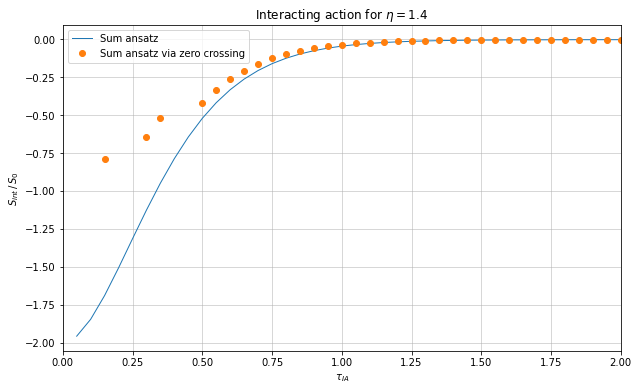

In [23]:
# Plotting the interacting term of the action
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(tIA_vec[1:], Sint_vec[1:], linewidth = 1, label = 'Sum ansatz')
ax.plot(tIA_ZC[1:], Sint_vec_ZC[1:], 'o', label = 'Sum ansatz via zero crossing')
plt.xlim([0, 2])
ax.set_xlabel('$\\tau_{IA}$')
ax.set_ylabel('$S_{int}\, /\, S_0$')
plt.grid(linewidth = 0.5)
plt.title('Interacting action for $\eta =$' + str(eta));
plt.legend()
plt.show()

## Monte Carlo
We now perform a Monte Carlo simulation to study the instanton distribution with respect to their reciprocal distance in the lattice. The action considered here is the free one, and the interaction is extracted from the resulting distribution (_effective interaction_). After $N_{cor}$ update sweeps, the configuration is cooled and the distances between instantons are measured. The procedure is the repeated for $N_{sweeps}$ times, and the overall number of instantons per distance is plotted in a histogram.

In [10]:
# Function that evaluates the action of a given configuration considering only j-dependent terms
def Sj(j, x):
    if j == 0:
        Action = (x[0] - x[N-1])**2 / (4*a) + a*(x[0]**2 - eta**2)**2      # Periodic boundary conditions
    else:
        Action = (x[j] - x[j-1])**2 / (4*a) + a*(x[j]**2 - eta**2)**2
    
    return Action

In [12]:
eps = float(input("epsilon = ") or 0.5)

# Function that updates x according to Metropolis algorithm
def update(y):
    
    for j in range(N):
        old_y = y[j]                                    # Save the original values
        old_Sj = Sj(j,y)
        y[j] = y[j] + random.gauss(0, eps)              # Update x[j]
        dS = Sj(j,y) - old_Sj                           # Change in action
        
        if np.exp(-dS) < random.random():               # Metropolis acceptance criterium
            y[j] = old_y                                # Restore the old value in case the condition is not satisfied

# Function that updates x cooling the system
def cooling(y):
    
    for j in range(N):
        old_y = y[j]                                    # Save the original values
        old_S = Sj(j, y)
        y[j] = y[j] + random.gauss(0, eps*0.1)          # Update x[j]
        dS = Sj(j, y) - old_S                           # Change in action
        
        if dS > 0:                                      # Cooling condition
            y[j] = old_y                                # Restore the old value in case the condition is not satisfied

epsilon = 


### Monte Carlo instanton distribution

In [13]:
# Monte Carlo simulation to compute the instanton distribution
Nsweeps = int(input("Nsweeps = ") or 100)
Ncor = int(input("Ncor = ") or 100)
Ncool = int(input("Ncool = ") or 200)

x = np.zeros(N)
disMC = []             # List of distances

for k in tqdm(range(Nsweeps), leave = False):
    for j in range(Ncor):
        update(x)
    
    y = x              # Temporary variable
    
    for j in range(Ncool):
        cooling(y)
    
    disMC.append(dist(y))        # Compute and store distances
    
disMC = list(itertools.chain.from_iterable(disMC))               # Transform a list of lists into a unique list

Nsweeps = 1000
Ncor = 
Ncool = 


  0%|          | 0/1000 [00:00<?, ?it/s]

Nbins = 


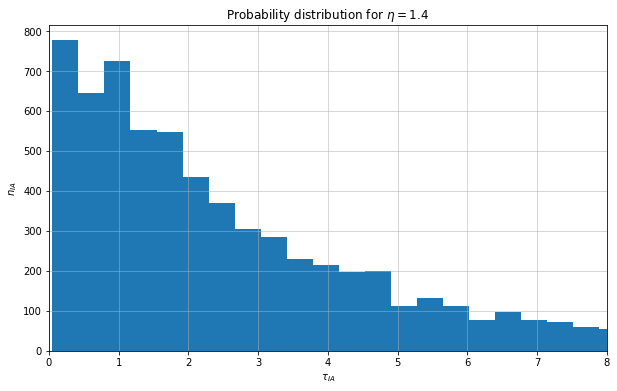

In [16]:
# Plotting the instanton distribution
Nbins = int(input("Nbins = ") or 60)

fig, ax = plt.subplots(figsize = (10,6))
nMC, _, _ = plt.hist(disMC, Nbins)
ax.set_xlabel('$\\tau_{IA}$')
ax.set_ylabel('$n_{IA}$')
plt.xlim([0, 8])
plt.grid(linewidth = 0.5)
plt.title('Probability distribution for $\eta =$' + str(eta));
plt.show()

### Comparison with RILM
The data above can be compared with the instanton density distribution obtained from a random gas of instanton, with no interacting term in the action as well. For future use, the number of sweeps $N_{sweeps}$ needs to be the same.

In [24]:
# RILM instanton distribution
deltaz = float(input("deltaz = ") or 1)

z = np.zeros(Nin)
x = np.zeros(N)
dis = []                                     # List of distances

# Initial configuration & action
setup(Nin, z, beta)
z = sorted(z)
xconf(Nin, eta, z, x)
Stot = S(x)

for k in tqdm(range(Nsweeps), leave = False):         
    for j in range(Nin):
        Sold = Stot
        z_store = z               # Store the value of z in case Metropolis conditions will not be satisfied
        zold = z[j]  
        
        znew = zold + (random.random() - 0.5)*deltaz;           # Update the z element
        
        if znew > beta:           # Boundary conditions
            znew = znew-beta
        if znew < 0:
            znew = znew+beta
        
        z[j] = znew               # Plug the new z element in z vector
        z = sorted(z)
        
        xconf(Nin, eta, z, x)
        Snew = S(x)
        delS = Snew - Sold
        
        if np.exp(-delS) > random.random():           # Metropolis condition
            Stot = Snew
        else:
            z = z_store
    
    xconf(Nin, eta, z, x)
    z = sorted(z)
    
    for j in range(Nin-1):
        dis.append(z[j+1] - z[j])                     # Adding the list of distances to list

deltaz = 


NameError: name 'Nsweeps' is not defined

In [79]:
def smooth(x):
    sl = 2
    
    for j in range(sl, len(x)-sl, sl):
        for i in range(j-sl, j+sl):
            x[i] = x[j]
    
    return x

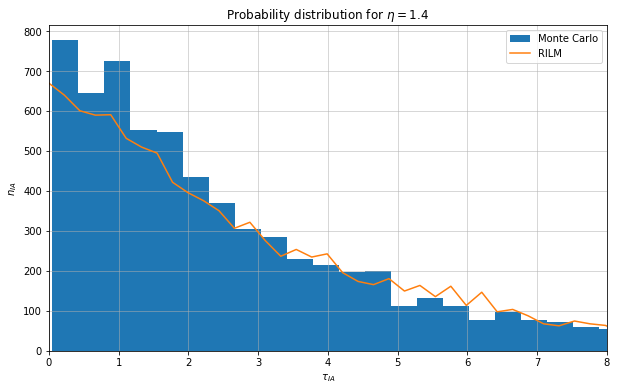

In [18]:
# Plotting the instanton distribution
fig, ax = plt.subplots(figsize = (10,6))
ax.hist(disMC, Nbins, label = 'Monte Carlo')

nRILM, bins = np.histogram(dis, Nbins)
ax.plot(bins[:-1], nRILM, label = 'RILM')

ax.set_xlabel('$\\tau_{IA}$')
ax.set_ylabel('$n_{IA}$')
plt.xlim([0, 8])
plt.grid(linewidth = 0.5)
plt.title('Probability distribution for $\eta =$' + str(eta));
plt.legend()
plt.show()

### Estimate of effective interaction
The enhancement in the instanton distribution that we observe around $\tau_{IA}\sim 0$ can be used to estimate the effective interaction between instantons. We try this estimate here by means of the classical relation:

$$
n(\tau_{IA}) = n_0(\tau_{IA}) e^{-S_{IA}(\tau_{IA})}\qquad\longrightarrow\qquad
S_{IA}(\tau_{IA}) = -\log{\frac{n(\tau_{IA})}{n_0(\tau_{IA})}}
$$

where $n(\tau_{IA})$ is the number of instantons in the Monte Carlo simulation as a function of instanton-anti-instanton separation, while $n_0(\tau_{IA})$ is the instanton distribution in the random theory (RILM).

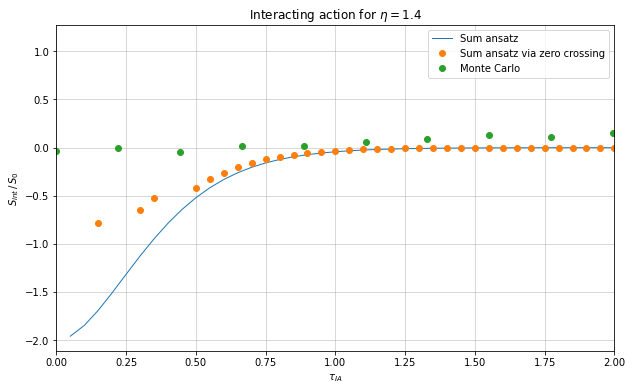

In [19]:
# Interacting action estimate from instanton density
remove = np.where(nRILM*nMC == 0)[0]                # Remove points where nRILM = 0 or nMC = 0
nRILM = np.delete(nRILM, remove)
nMC = np.delete(nMC, remove)

Sint_MC = - np.log(nMC / nRILM)/S0

tIA_RILM = bins[:-1]
tIA_RILM = np.delete(tIA_RILM, remove)

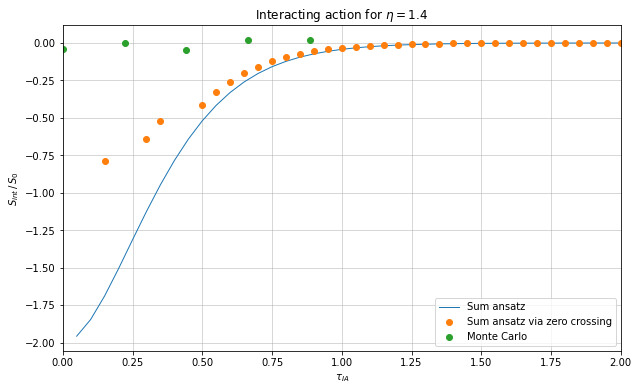

In [23]:
# Adding this data to the previous plot
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(tIA_vec[1:], Sint_vec[1:], linewidth = 1, label = 'Sum ansatz')
ax.plot(tIA_ZC[1:], Sint_vec_ZC[1:], 'o', label = 'Sum ansatz via zero crossing')
ax.plot(tIA_RILM[0:5], Sint_MC[0:5], 'o', label = 'Monte Carlo')
plt.xlim([0, 2])
ax.set_xlabel('$\\tau_{IA}$')
ax.set_ylabel('$S_{int}\, /\, S_0$')
plt.grid(linewidth = 0.5)
plt.title('Interacting action for $\eta =$' + str(eta));
plt.legend()
plt.show()

## Hard core interaction
In order to include interactions between instantons, we consider the simplest case of a short-range repulsive core that excludes configurations with close instanton-anti-instanton pairs (which are not semiclassical configurations). In particular, here we include in the action an interacting term of the form:

$$
S_{core}(\tau_{IA})=A_c\ \mbox{exp}\left(-\frac{\tau_{IA}}{\tau_C}\right)
$$

where $\tau_{IA} = |\tau_I - \tau_A|$ is the instanton-anti-instanton separation, $\tau_C\sim 0.3$ is the range of hard core interaction, and $A_{c}\sim 3$ is its strength.

In [10]:
# Hard core interaction parameters
Tcore = float(input("Tcore = ") or 0.3)
Acore = float(input("Acore = ") or 3)

Score = Acore*S0          # Classical action for the hard core interaction

Tcore = 
Acore = 


In [11]:
# Evaluating the hard core interaction term in the action
def Shc(z, Nin):
    S_hc = 0
    
    if Tcore == 0:         # If the interaction has zero radius, the associated action vanishes
        return
    
    for j in range(Nin):
        if j == 0:
            zm = z[Nin-1] - beta               # Periodic boundary conditions
        else:
            zm = z[j-1]
        
        dz = z[j] - zm                         # Instanton-anti-instanton separation from vector z
        S_hc = S_hc + Score*np.exp(-dz/Tcore)    # Interacting action obtained as a sum of all terms
    
    return S_hc

## Interacting instanton configuration
To see the effects of introducing the hard core interaction between instantons we can plot the evolution of the instanton locations $z$ as the configuration evolves through Metropolis sweeps.

In [28]:
# Interacting instanton configuration
Nsweeps = int(input("Nsweeps = ") or 100)
deltaz = float(input("deltaz = ") or 1)

z_matrix = np.zeros((Nsweeps, Nin))          # Store of z-positions for all instantons, required for next plot
z = np.zeros(Nin)
x = np.zeros(N)

# Initial configuration & action
setup(Nin, z, beta)
z = sorted(z)
xconf(Nin, eta, z, x)
Stot = S(x) + Shc(x, Nin)

for k in tqdm(range(Nsweeps), leave = False):         
    for j in range(Nin):
        Sold = Stot
        zold = z[j]
        z_store = z         # Store the value of z in case the Metropolis conditions will not be satisfied
        
        znew = zold + (random.random() - 0.5)*deltaz;           # Update the z element
        
        if znew > beta:           # Boundary conditions
            znew = znew
        if znew < 0:
            znew = znew
        
        z[j] = znew               # Plug the new z element in z vector
        z = sorted(z)
        
        xconf(Nin, eta, z, x)
        Snew = S(x) + Shc(z, Nin)
        delS = Snew - Sold
        
        if np.exp(-delS) > random.random():           # Metropolis condition
            Stot = Snew
        else:
            z = z_store
    
    xconf(Nin, eta, z, x)
    z_matrix[k, :] = z            # Saving the final values of z for this configuration

Nsweeps = 
deltaz = 


  0%|          | 0/100 [00:00<?, ?it/s]

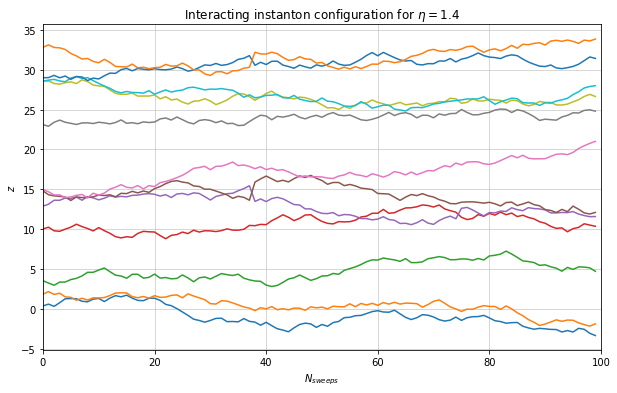

In [30]:
# Plotting the interacting instanton configuration
fig, ax = plt.subplots(figsize = (10,6))
ax.plot([j for j in range(Nsweeps)], z_matrix)
ax.set_xlabel('$N_{sweeps}$')
ax.set_ylabel('$z$')
plt.xlim([0, Nsweeps])
plt.grid(linewidth = 0.5)
plt.title('Interacting instanton configuration for $\eta =$' + str(eta));

## Streamline method
This alternative method for computing the interaction term in the action is based on the fact that in the space of instanton-anti-instanton paths there is one almost flat direction along which the action slowly varies between the classical values $2S_0$ and $0$; all other directions correspond to perturbative fluctuations. We can force the instanton-anti-instanton path to descend along the almost flat direction by adding a constraint:

$$
S_\xi = \xi(\lambda)\int d\tau\ \left[x(\tau)-x_\lambda(\tau)\right]\ \frac{dx_\lambda(\tau)}{d\lambda}
$$

where $\lambda$ labels different instanton-anti-instanton paths along the streamline $x_\lambda(\tau)$, and $\xi(\lambda)$ is a Lagrange multiplier. It is an arbitrary function, that reflects the reparametrization invariance of the streamline solution. The streamline configuration is found by starting from a well separated instanton-anti-instanton pair and letting the system evolve using the method of steepest descent, that is, by solving:

$$
\xi(\lambda)\ \frac{dx_\lambda(\tau)}{d\lambda} = \left.\frac{\delta S}{\delta x(\tau)}\right|_{x=x_\lambda}
$$

with the boundary condition that $x_{\lambda=0}(\tau)\simeq x_{sum}(\tau)$ corresponds to the sum ansatz with a well separated instanton-anti-instanton pair.

Input parameters, with defaul values:
- initial instanton-anti-instanton separation: $R_0=1.8$
- streamline equation time step: $d\lambda = 0.001$
- number of lattice points: $n = 100$

In [29]:
# Input parameters for the streamline equation solver
R0 = float(input("R0 = ") or 1.8)
dl = float(input("dlambda = ") or 0.001)
n = int(input("n = ") or 100)

R0 = 
dlambda = 
n = 


### Streamline action
The following function computes the action of a streamline configuration $x$. The instanton will be generated with centre in $\tau = 0$ for simplicity, so the euclidean lattice is centred in zero as well. The first derivative of $x$ is discretized as usual, but since the streamline equation involves variations of the action as well, we need to compute $\ddot x$. The second derivative of $x$ is discretized as:

$$
\ddot{x}(\tau=ja) \approx \frac{-x_{j+2}+16x_{j+1}-30x_j+16x_{j-1}-x_{j-2}}{12a^2}
$$

and the variation of the action will be:

$$
\left.\frac{\delta S}{\delta x(\tau)}\right|_{x=x_\lambda}= -\frac{1}{2}\ddot{x} + 4x(x^2-\eta^2)
$$

In [30]:
# Function that computes the action of a given streamline configuration and its derivative
def Sstream(x):
    Stot = 0
    derS = np.zeros(n+4)        # Derivative of the action
    S_vec = np.zeros(n+4)       # For plotting
    
    for j in range(n+2):
        tau = j*a - n*a/2                                     # Euclidean lattice centred in zero
        xdot = (x[j+1] - x[j-1]) / (2*a)
        S_vec[j] = xdot**2/4 + (x[j]**2 - eta**2)**2
        Stot = Stot + S_vec[j]*a
        
        # Derivative of the action
        xddot = (-x[j+2] + 16*x[j+1] - 30*x[j] + 16*x[j-1] - x[j-2]) / (12*a**2)
        derS[j] = -xddot/2 + 4*x[j]*(x[j]**2 - eta**2)
    
    return Stot, S_vec, derS

### Discretized streamline equation
The streamline equation is then discretized letting $x_\lambda(\tau)$ evolve at small steps $d\lambda$. The initial configuration is given by the sum ansatz with an instanton and anti-instanton located at $\pm\frac{1}{2}R_0$; the configuration then evolves according to the following discretized version of the equation:

$$
x\longrightarrow x - \left.\frac{\delta S}{\delta x(\tau)}\right|_{x=x_\lambda}d\lambda
$$

In [31]:
# Solving the streamline equation
nmax = int(input("nmax = ") or 7*10**4)

tauI = -R0/2         # Instanton and anti-instanton position
tauA = R0/2
Nin = 2              # Total instanton number

tau_vec = np.zeros(n+4)
x = np.zeros(n+4)

# Building the initial configuration (sum ansatz with two instantons)
for j in range(n+4):
    tau = j*a - n*a/2
    tau_vec[j] = tau
    x[j] = eta*(np.tanh(2*eta*(tau-tauI)) - np.tanh(2*eta*(tau-tauA)) - 1)

xmatrix = np.zeros((n+4, nmax))
Smatrix = np.zeros((n+4, nmax))

for k in tqdm(range(nmax), leave = False):
    _, _, derS = Sstream(x)          # Compute the derivative of the action
    x = x - derS*dl                  # Update in x
    xmatrix[:, k] = x                # Save x value
    
    _, S_vec, _ = Sstream(x)         # Streamline configuration action
    Smatrix[:, k] = S_vec            # Save S value

nmax = 


  0%|          | 0/70000 [00:00<?, ?it/s]

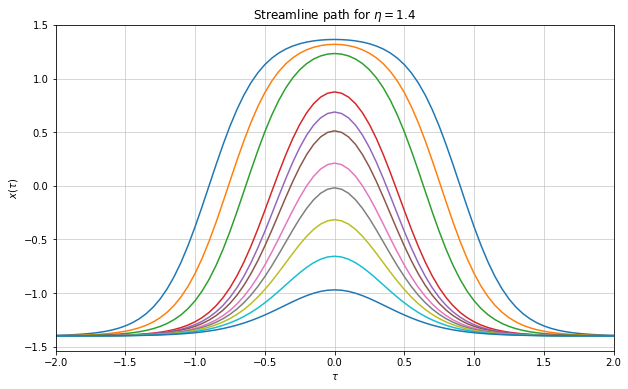

In [32]:
# Plotting the streamline solution
fig, ax = plt.subplots(figsize = (10,6))

samplepaths = [0, 50000, 60000, 63000, 63200, 63300, 63400, 63450, 63500, 63550, 63600]

ax.plot(tau_vec, xmatrix[:, samplepaths])

ax.set_xlabel('$\\tau$')
ax.set_ylabel('$x(\\tau)$')
plt.xlim([-2, 2])
plt.grid(linewidth = 0.5)
plt.title('Streamline path for $\eta =$' + str(eta));

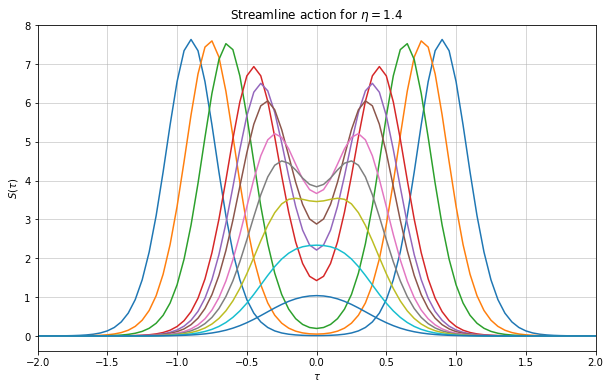

In [33]:
# Plotting the streamline action
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(tau_vec, Smatrix[:, samplepaths])

ax.set_xlabel('$\\tau$')
ax.set_ylabel('$S(\\tau)$')
plt.xlim([-2, 2])
plt.grid(linewidth = 0.5)
plt.title('Streamline action for $\eta =$' + str(eta));

### Interaction action for streamline solutions
We can now evaluate the interaction term for the solutions of the streamline equation as a function of the distance between the instanton and anti-instanton solution. The latter is computed using the above function, while the interacting action comes from subtracting the classical term from the total action, therefore leaving only fluctuations:
$$
S_{int}[x] = S[x] - N_{I}S_0 = S[x] - \frac{8\eta^3}{3}
$$

When the path does not crosses zero, the distance is set to be zero, and the values are removed from the array.

In [34]:
# Interaction term in the action for streamline solutions
toplot = [50000, 55000, 58000, 60000, 62000, 62500, 62800, 63000, 63200, 63300, 63350, 63400]

dis_stream = np.zeros(len(toplot)+1)
Sint_stream = np.zeros(len(toplot)+1)

i = 0       # Index for arrays to include in plot

for j in toplot:
    x0 = xmatrix[:, j]
    distance = dist(x0)          # Evaluate the distance
    
    if distance == []:           # The path does not cross zero
        dis_stream[i] = 0
        Sint_stream[i] = 0
    else:
        dis_stream[i] = distance[0]           # List to float
        Stot, _, _ = Sstream(x0)              # Total action
        Sint_stream[i] = (Stot - Nin*S0)/S0        # Interacting action
        
    i = i+1

# Remove zero values from the arrays to be included in plot
dis_stream = dis_stream[dis_stream != 0]
Sint_stream = Sint_stream[Sint_stream != 0]

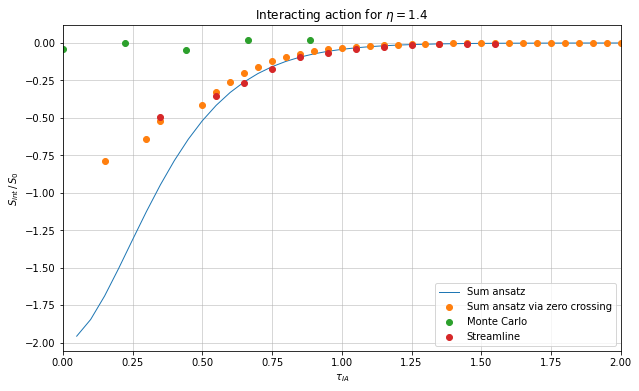

In [35]:
# Adding this data to the previous plot
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(tIA_vec[1:], Sint_vec[1:], linewidth = 1, label = 'Sum ansatz')
ax.plot(tIA_ZC[1:], Sint_vec_ZC[1:], 'o', label = 'Sum ansatz via zero crossing')
ax.plot(tIA_RILM[0:5], Sint_MC[0:5], 'o', label = 'Monte Carlo')
ax.plot(dis_stream, Sint_stream, 'o', label = "Streamline")
plt.xlim([0, 2])
ax.set_xlabel('$\\tau_{IA}$')
ax.set_ylabel('$S_{int}\, /\, S_0$')
plt.grid(linewidth = 0.5)
plt.title('Interacting action for $\eta =$' + str(eta));
plt.legend()
plt.show()